 # Camera tracking
 
 create block diagram
 and system drawing
 create specs
 read datasheet
 simulate actuator
 simulate open loop system

## Content

1. control theory 
2. piezo actuator close - loop and open-loop charecteristic
3. full system block diagram
4. controller architecture
5. code
6. scipy relevant function

**S-335 actuator**
https://www.physikinstrumente.com/en/products/nanopositioning-piezo-flexure-stages/piezo-flexure-tilting-mirrors/s-335-piezo-tiptilt-platform-300711#downloads

**E-727 driver**
https://www.physikinstrumente.com/en/products/controllers-and-drivers/nanopositioning-piezo-controllers/e-727x-e-727xp-digital-multi-channel-piezo-controller-412418442

In [1]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt


## Control theory

### 2nd order system
$ x_n=\frac{1}{N} \sum_{k=0}^{N-1} X_k\cdot e^{i\frac{2\pi}{N}kn}$

$ \frac{1}{s^2+\frac{c}{m}s+\frac{k}{m}}$

$ \frac{1}{s^2+2\cdot\zeta\cdot w_{n}\cdot s+w_{n}^{2}}$

### frquency response
frquency response of a system is the  dft of the system impulse response 

stability, response, pros and cons
#### bode diagram 

#### nyquist

#### nichols

### notch filter

### digitization

### stability

## piezo actuator close - loop and open - loop charecteristic

### open - loop
the open loop is is an undamped 2nd order system with resonance around 0.6-1.6 khz( depends on the load)

### close - loop
the servo controlled optimzed driver close - loop system is a 2nd order damped system with about 300 hz bandwidth

## full system block diagram

## controller architecture

The input signal is step(not single but many) and a band of sines in around 50 hz whos riding on it.

the signal is a laser dot which were trying to locate in the center of camera.
the camera is located on a gimbal( for large movements, thus the steps)
and rotating on a circle in 50 hz(approximatly)

we have couple of goals:
1. attenuate the arae around 50 hz
2. get good rise time
3. small!! over - shoot
4. stability

will use the following system:
2nd order with the pole p=160j-150 and its conjugate


* our controller will combine a notch filter and a PID(with only P for now)

(-150+160j)
(-150-160j)
[48100.0] [1, (300+0j), (48100+0j)]
[5.000e-02+0.j 1.600e+01+0.j 2.705e+03+0.j 4.810e+04+0.j]
ZerosPolesGainContinuous(
array([], dtype=float64),
array([-150.+160.j, -150.-160.j]),
(48100+0j),
dt: None
)
ZerosPolesGainContinuous(
array([-80.+0.j]),
array([-150.+160.j, -150.-160.j,  -20.  +0.j]),
(18037.5+0j),
dt: None
)
bw= 73 298.364724028334
bw= 73 -3.109384912504816


C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\lib\site-packages\scipy\signal\filter_design.py:1632: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


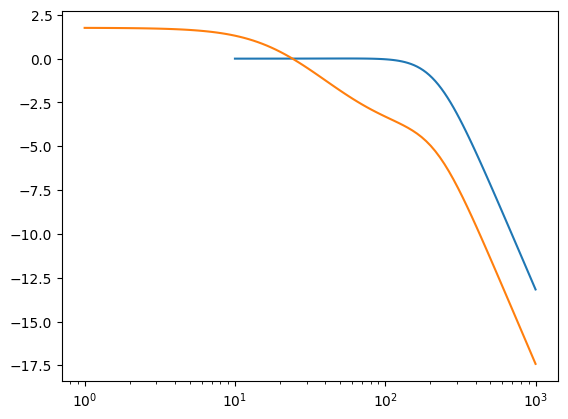

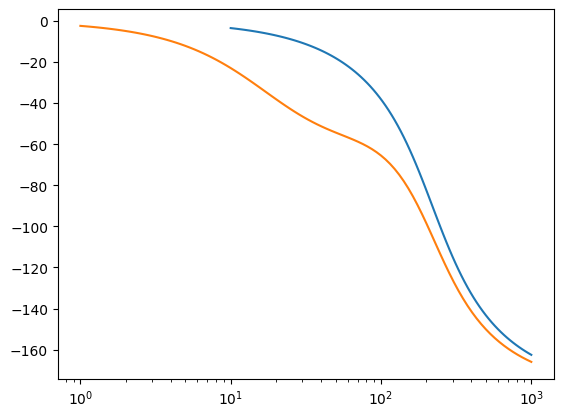

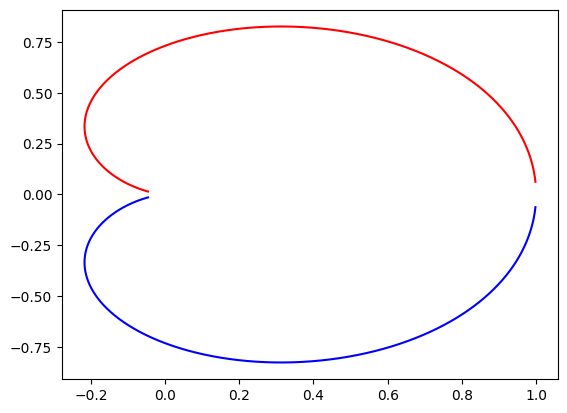

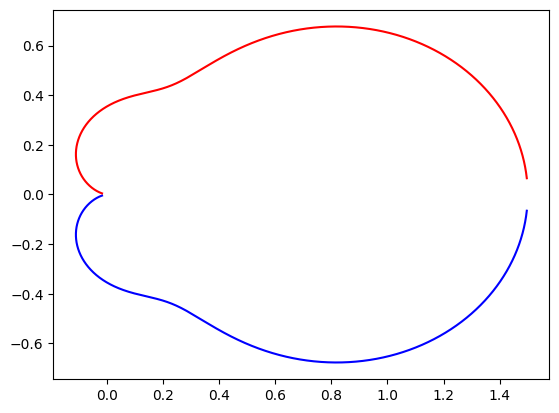

C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\lib\site-packages\scipy\signal\ltisys.py:3506: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(system.B, u_dt[i, :]))
C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\lib\site-packages\scipy\signal\ltisys.py:3508: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(system.D, u_dt[i, :]))
C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\lib\site-packages\scipy\signal\ltisys.py:3512: ComplexWarning: Casting complex values to real discards the imaginary part
  np.dot(system.D, u_dt[out_samples-1, :]))
C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


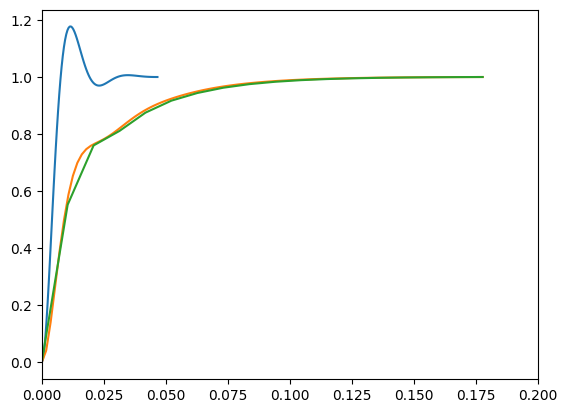

os is  (1.1770080753890326+0j) (1+0j)
rt is  0.0056565656565656566 0.010776191602848253



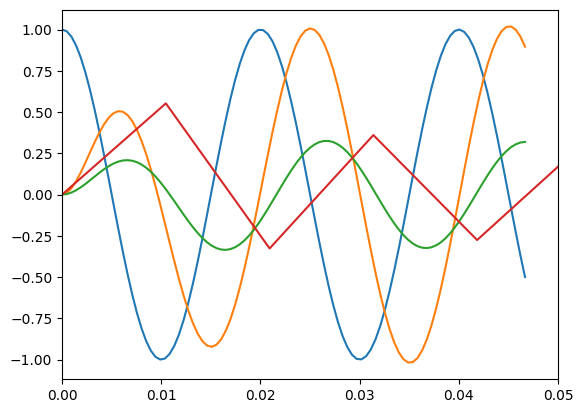

In [2]:

bw=160j
sig=-150

p=bw+sig
print(p)
print(np.conjugate(p))
num=[np.abs(p*np.conjugate(p))]
den=[1, -p-np.conjugate(p), p*np.conjugate(p)]
print(num,den)
lin_sys=scipy.signal.TransferFunction(num, den)
k=1.5
notch_num,notch_den=[k*1/80, k*1],[1/20, 1]
notch_num,notch_den=np.polymul(notch_num,num),np.polymul(notch_den,den)
print(notch_den)
lin_sys2=scipy.signal.TransferFunction(notch_num, notch_den)

lin_sys_cl=scipy.signal.TransferFunction(num,np.polyadd(num,den))
lin_sys2_cl=scipy.signal.TransferFunction(notch_num, np.polyadd(notch_num, notch_den))
lin_sys2_cl_d=lin_sys2_cl.to_discrete(0.01, method='zoh', alpha=None)


w, mag, phase =scipy.signal.bode(lin_sys, w=None, n=100)
mag=mag/2

w2, mag2, phase2 =scipy.signal.bode(lin_sys2, w=None, n=100)
mag2=mag2/2
print(lin_sys.to_zpk())
print(lin_sys2.to_zpk())


print("bw=",np.where(mag<-3)[0][0], w[np.where(mag<-3)[0][0]])
print("bw=",np.where(mag<-3)[0][0], mag[np.where(mag<-3)[0][0]])

# open loop bode
plt.figure()
plt.semilogx(w, mag, w2, mag2)    # Bode magnitude plot
plt.figure()
plt.semilogx(w, phase, w2, phase2)  # Bode phase plot
plt.show()

# stability
w, H = scipy.signal.freqresp(lin_sys)
plt.figure()
plt.plot(H.real, H.imag, "b")
plt.plot(H.real, -H.imag, "r")
plt.show()

w2, H2 = scipy.signal.freqresp(lin_sys2)
plt.figure()
plt.plot(H2.real, H2.imag, "b")
plt.plot(H2.real, -H2.imag, "r")
plt.show()

# root locus

# step response
u=lin_sys_cl.step(X0=None, T=None, N=None)
u2=lin_sys2_cl.step(X0=None, T=None, N=None)

u3=scipy.signal.dstep(lin_sys2_cl_d, x0=None, t=u2[0], n=None)



factor1,factor2, factor3=1/u[1][-1],1/u2[1][-1],1/u3[1][0][-1]
plt.plot(u[0],u[1]*factor1,u2[0],u2[1]*factor2,u3[0],u3[1][0]*factor3)
plt.xlim([0,0.2])
plt.show()
print("os is ",np.max(u[1]*factor1)/1, np.max(u2[1]*factor2)/1)
print("rt is ",u[0][np.where(u[1]>0.7*u[1][-1])[0][0]], u2[0][np.where(u2[1]>0.7*u[1][-1])[0][0]])

# sine responses 
U=np.cos(2*np.pi*50*u[0])
U2=np.cos(2*np.pi*50*u2[0])
U_out=scipy.signal.lsim(lin_sys_cl, U, u[0], X0=None, interp=True)
U_out2=scipy.signal.lsim(lin_sys2_cl, U, u[0], X0=None, interp=True)
print()
U_out3=scipy.signal.dlsim(lin_sys2_cl_d, U2, u2[0])

plt.plot(u[0],U,u[0],U_out[1]*factor1,u[0],U_out2[1]*factor2,u3[0],U_out3[1]*factor3)
plt.xlim([0,0.05])
plt.show()

## scipy relevant functions
